# purity of $CC1p$ in the selected events-sample

In [1]:
from Xsec_setup import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/Xsec/Figures/background_subtraction/'

In [3]:
versions['overlay date'] = '2018_08_16'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
selected_path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/'
prefix = selected_path + versions['Overlay'] + '_' + versions['overlay date'] + '_'
selected_overlay=dict()

cuts_order  = ['no cut','Chi2Proton','Nflashes','MatchedFlash','length'
               ,'non-collinearity','vertex activity'
               ,'delta phi','Pt & delta phi']
cutlabels = ['preselection','$dE/dx$ profile',r'$N_{flashes}>0$','optical filter','track lengths'
             ,'non-collinearity','vertex activity'
             ,'coplanarity','$p_t<0.35$ GeV/c']

if os.path.isfile(prefix+'selected_cosmic.csv'): 
    print 'checked',prefix+'selected_cosmic.csv','and found the file...'
    for pair_type in pair_types:
        selected_overlay[pair_type]=pd.read_csv(prefix+'selected_'+pair_type+'.csv')

else:
    print 'checked',prefix+'selected_cosmic.csv','and there was no file there...'
    OverlaySamples = load_samples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')
    reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order)
    print 'applied cuts to overlay'
    for pair_type in pair_types:
        selected_overlay[pair_type] = reducedOverlay['Pt & delta phi'][pair_type]
        outcsvname = prefix+'selected_'+pair_type+'.csv'
        selected_overlay[pair_type].to_csv(outcsvname)
        print 'saved selected',pair_type,'to',outcsvname
    
    # overlay scaling
    summary = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/summary/'+versions['overlay date']+'/'+versions['Overlay']+'_'+versions['overlay date']+'_summary.csv')
    Nevents['OnBeam POT'] = 4.908e+19
    Nevents['overlay']      = np.sum(summary.Nevents)
    Nevents['overlay POT']  = np.sum(summary.POT)
    Nevents['f(POT)']       = Nevents['OnBeam POT']/Nevents['overlay POT']
    print "Nevents['f(POT)']:",Nevents['f(POT)']

selected_overlay_concat = pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])    
print len(selected_overlay_concat),'events in the overlay'

checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_cosmic.csv and found the file...
13551 events in the overlay


In [4]:
versions['data date'] = '2018_08_16'
versions['beam on'] = 'prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off'] = 'prod_reco_optfilter_extbnb_v12_mcc8_dev'
prefix = selected_path + versions['beam on'] + '_' + versions['data date'] + '_'

if os.path.isfile(prefix+'selected_beam_on.csv'):
    print 'checked',prefix+'selected_on_beam.csv and found the file...'
    selected_beam_on = pd.read_csv(prefix+'selected_beam_on.csv')
    selected_beam_off = pd.read_csv(prefix+'selected_beam_off.csv')

else:
    print 'checked',prefix+'selected_on_beam.csv and there was no file there...'
    OnBeam = pd.concat([pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['beam on']+'_04_'+versions['data date']+'_vertices.csv')
                        ,pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['beam on']+'_05_'+versions['data date']+'_vertices.csv')])
    print 'loaded beam-on'
    OffBeam = pd.concat([pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['beam off']+'_04_'+versions['data date']+'_vertices.csv')
                        ,pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['beam off']+'_05_'+versions['data date']+'_vertices.csv')])
    print 'loaded beam-off'
    reducedOnBeam,reducedOffBeam,numbers = apply_cuts_to_data(OnBeam=OnBeam,OffBeam=OffBeam,cuts_order=cuts_order)
    print 'applied cuts to data'
    selected_beam_on = reducedOnBeam['Pt & delta phi']
    outcsvname = prefix+'selected_beam_on.csv'
    selected_beam_on.to_csv(outcsvname)
    print 'saved selected beam on to',outcsvname

    selected_beam_off = reducedOffBeam['Pt & delta phi']
    outcsvname = prefix+'selected_beam_off.csv'
    selected_beam_off.to_csv(outcsvname)
    print 'saved selected beam on to',outcsvname
    
print len(selected_beam_on),'events in the beam-on'
print len(selected_beam_off),'events in the beam-off'

checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prod_reco_optfilter_bnb_v12_unblind_mcc8_2018_08_16_selected_on_beam.csv and found the file...
454 events in the beam-on
25 events in the beam-off


## Background subtraction

In [9]:
def subtrsact_bkg_1d(bins=Bins['Pmu'],xlabel=Labels['Pmu'],xvar='reco_Pmu_mcs',mul=1):
    mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
    h,herr = dict(),dict()
    
    # data
    for sam,label in zip([selected_beam_off,selected_beam_on],['beam off','beam on']):
        h[label],_ = np.histogram( mul*sam[xvar] , bins=bins )
        herr[label] = np.sqrt(h[label])
    # MC
    for sam,label in zip([selected_overlay_concat,selected_overlay['CC 1p']],['overlay','CC 1p']):
        h[label],_ = np.histogram( mul*sam[xvar] , bins=bins )
        h[label] = h[label]*Nevents['f(POT)']
        herr[label] = np.sqrt(h[label])*Nevents['f(POT)']

    h['ovrelay + beam off'] = h['overlay'] + h['beam off']
    herr['overlay + beam off'] = np.sqrt(np.square(herr['overlay']) + np.square(herr['beam off']))
    h['background'] = h['ovrelay + beam off'] - h['CC 1p']
    herr['background'] = np.sqrt(np.square(herr['overlay + beam off']) + np.square(herr['CC 1p']))
    h['beam on bkg subtracted'] = h['beam on'] - h['background']
    herr['beam on bkg subtracted'] = np.sqrt(np.square(herr['beam on']) + np.square(herr['background']))


    fig = plt.figure(figsize=(20,6))
    ax=fig.add_subplot(1,2,1)
    ax.bar( mid , h['overlay']+h['beam off'] , width=2*bin_width , color=Colors['beam off'], label='beam-off',alpha=0.7)
    ax.bar( mid , h['overlay'] , width=2*bin_width, color=Colors['overlay'], label='overlay',alpha=0.7)
    ax.bar( mid , h['CC 1p'], width=2*bin_width, color=Colors['CC 1p'], label=r'CC 1p signal')
    ax.errorbar( x=mid , xerr=bin_width, y=h['beam on'], yerr=herr['beam on'] , fmt='o', markersize=10 
                , color=Colors['beam on'], capsize=1, capthick=3, label='beam-on')
    set_axes(ax,xlabel,do_add_legend=True)
    ylim = ax.get_ylim()

    ax=fig.add_subplot(1,2,2)
    ax.bar( mid , h['CC 1p'], width=2*bin_width, color=Colors['CC 1p'])
    ax.errorbar( x=mid , xerr=bin_width, y=h['beam on bkg subtracted'], yerr=herr['beam on bkg subtracted'] , fmt='o', markersize=10 
                , color=Colors['beam on'], capsize=1, capthick=3, label='beam-on')
    set_axes(ax,xlabel,do_add_legend=True,ylim=ylim)   

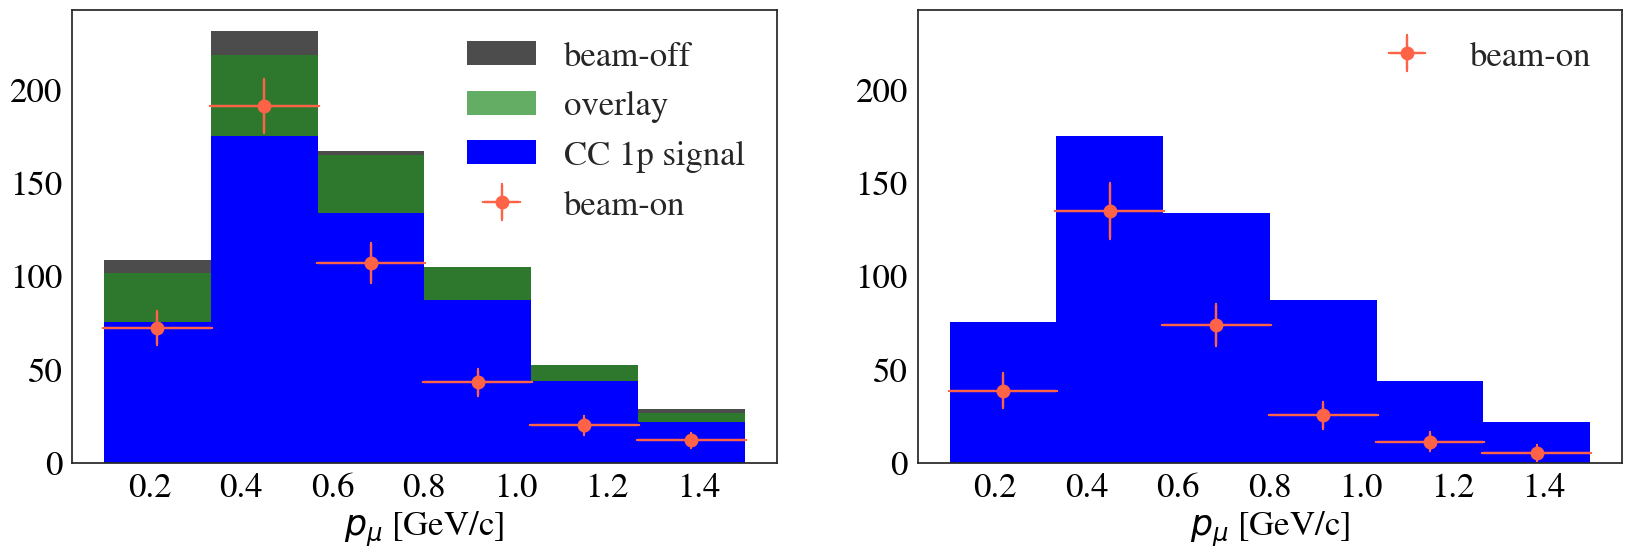

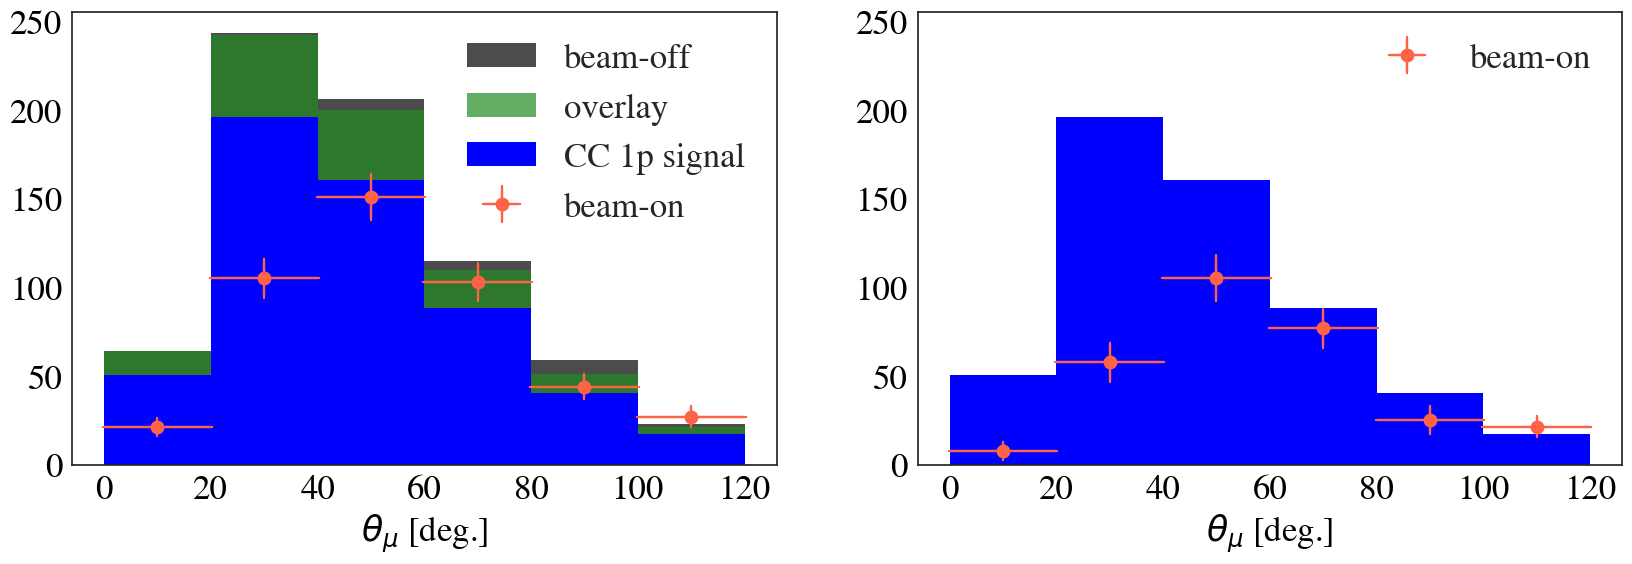

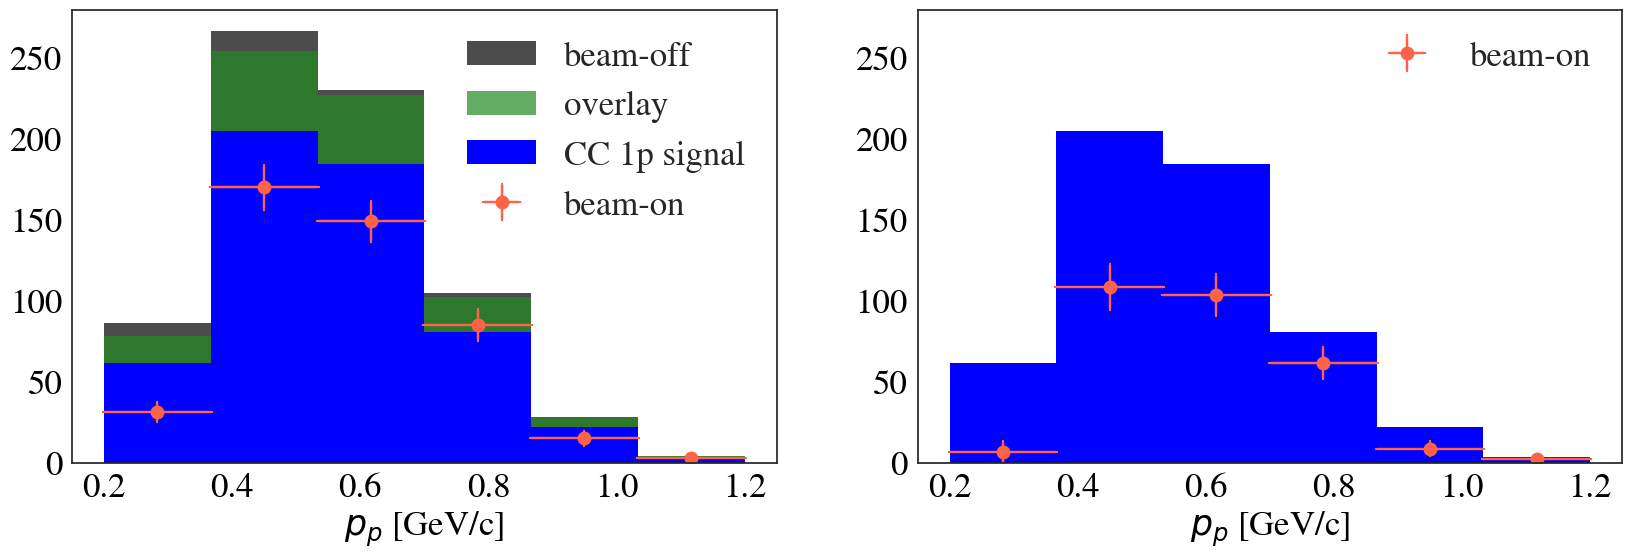

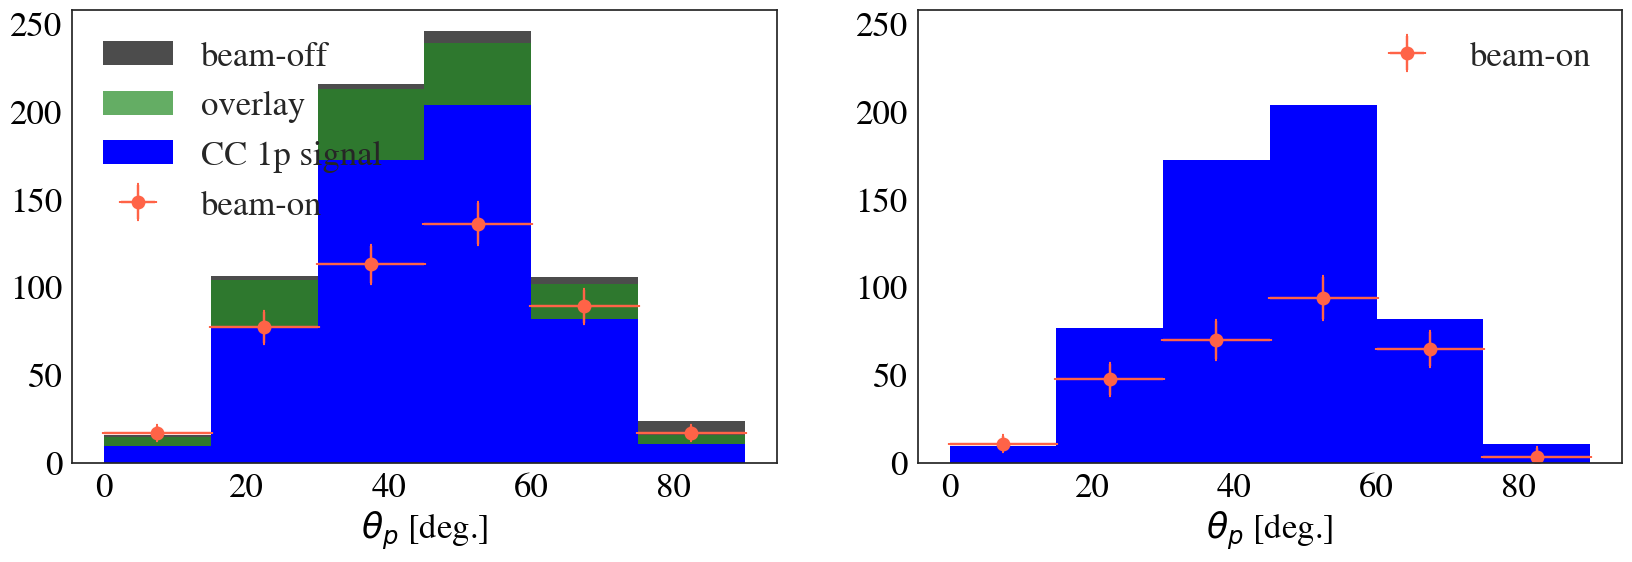

In [10]:
subtrsact_bkg_1d(bins=Bins['Pmu'],xlabel=Labels['Pmu'],xvar='reco_Pmu_mcs')
subtrsact_bkg_1d(bins=Bins['theta(mu)'],xlabel=Labels['theta(mu)'],xvar='reco_Pmu_mcs_theta',mul=180./np.pi)
subtrsact_bkg_1d(bins=Bins['Pp'],xlabel=Labels['Pp'],xvar='reco_Pp')
subtrsact_bkg_1d(bins=Bins['theta(p)'],xlabel=Labels['theta(p)'],xvar='reco_Pp_theta',mul=180./np.pi)